#### Explainability of CNNs using Grad-CAM

In [1]:
import os
import sys

if "google.colab" in sys.modules:
    workspace_dir = '/content/spam-detection'
    branch = 'feature/cnn-gradcam'
    current_dir = os.getcwd()
    if not os.path.exists(workspace_dir) and current_dir != workspace_dir:
        !git clone https://github.com/RationalEar/spam-detection.git
        os.chdir(workspace_dir)
        !git checkout $branch
        !ls -al
        !pip install -q transformers==4.48.0 scikit-learn pandas numpy
        !pip install -q torch --index-url https://download.pytorch.org/whl/cu126
        !pip install captum --no-deps --ignore-installed
    else:
        os.chdir(workspace_dir)
        !git pull origin $branch

    from google.colab import drive
    drive.mount('/content/drive')


In [2]:
import torch

import pandas as pd
from utils.constants import DATA_PATH, GLOVE_PATH

DATA_PATH

'/home/michael/PycharmProjects/spam-detection-data'

In [3]:
# Load the data
train_df = pd.read_pickle(DATA_PATH + '/data/processed/train.pkl')
test_df = pd.read_pickle(DATA_PATH + '/data/processed/test.pkl')

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cuda')

In [5]:
from utils.functions import set_seed, build_vocab

# Build vocabulary and load embeddings
set_seed(42)
word2idx, idx2word = build_vocab(train_df['text'])
embedding_dim = 300
max_len = 200

In [6]:
from preprocess.data_loader import load_glove_embeddings

pretrained_embeddings = load_glove_embeddings(GLOVE_PATH, word2idx, embedding_dim)

In [7]:
from models.cnn import SpamCNN

# Load the trained CNN model
model_path = DATA_PATH + '/trained-models/spam_cnn_final.pt'
cnn_model = SpamCNN(vocab_size=len(word2idx), embedding_dim=embedding_dim,
                    pretrained_embeddings=pretrained_embeddings)
cnn_model.load(model_path, map_location=device)  # map_location handled in load()
cnn_model = cnn_model
cnn_model.eval()

SpamCNN(
  (embedding): Embedding(25245, 300)
  (conv1): Conv1d(300, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(64, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [9]:
from utils.device_utils import reset_model_device

# Fix device mismatch issue
print("Fixing CNN model device mismatch...")
device = reset_model_device(cnn_model, target_device='cuda' if torch.cuda.is_available() else 'cpu')
print(f"Model reset to device: {device}")

Fixing CNN model device mismatch...
Model reset to device: cuda


In [10]:
from utils.functions import encode

# Prepare test data
X_test_tensor = torch.tensor([encode(t, word2idx, max_len) for t in test_df['text']])
y_test_tensor = torch.tensor(test_df['label'].values, dtype=torch.float32)

# Move data to device
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [11]:
# Get model predictions
with torch.no_grad():
    y_pred_probs = cnn_model(X_test_tensor)
    y_pred = (y_pred_probs > 0.5).float()

#### Grad-CAM for CNN

In [12]:
# Generate Grad-CAM explanations
# NOTE: Do NOT use torch.no_grad() here, as Grad-CAM needs gradients!
print("\nGenerating explanations...")
cam_maps, timing_info = cnn_model.grad_cam(X_test_tensor)

# Compute explainability metrics
exp_metrics = cnn_model.compute_explanation_metrics(X_test_tensor, cam_maps)

print("\nExplanation Quality Metrics:")
print(f"AUC-Del: {exp_metrics['auc_del']:.4f}")
print(f"AUC-Ins: {exp_metrics['auc_ins']:.4f}")
print(f"Comprehensiveness: {exp_metrics['comprehensiveness']:.4f}")
print(f"Stability Score: {exp_metrics['jaccard_stability']:.4f}")


Generating explanations...

Explanation Quality Metrics:
AUC-Del: 0.2055
AUC-Ins: 0.8446
Comprehensiveness: 0.0341
Stability Score: 0.6334


In [13]:
timing_info

{'grad_cam_time': 0.23435068130493164,
 'total_time': 0.23435187339782715,
 'batch_size': 606,
 'seq_length': 200,
 'time_per_message': 0.00038671729588272546}

In [14]:
samples = (150, 357, 402 , 416, 417, 604)
# display elements in the test set with the given indices
sample_df = test_df.iloc[list(samples)]
sample_df

,subject,text,label,source,sender_hash,reply_to_hash,date
150,Seeing is believing,seeing believing url <URL> author linda grant ...,0,easy_ham,e48634bb48df81f58894dfa459d8d363a55131ad80d90b...,,"Tue, 08 Oct 2002 08:01:07 -0000"
357,Apple Store eNews : November 2002,apple store enews november 2002 you appear usi...,0,hard_ham,44a1c8b4d70359a608e144a7037dd2c597de0c2a7e0687...,dc767a94b1b1941f8a66e2fd63d192f5bc284dabe81262...,"Wed, 27 Nov 2002 21:12:33 -0800"
402,RE: [ILUG] NVIDIA and Debian Woody,re ilug nvidia debian woody hi there now proba...,0,easy_ham_2,59681d3ae2f9791cb6b5dbc03c79f9f85d24779a117cb2...,,"Wed, 04 Dec 2002 04:05:38 -0600"
416,The Flight to Safety is Upon Us,flight safety upon us s not rush hour traffic ...,1,spam,559aee171ea8552beaf0f2b5558e92ffb8783618238bf1...,,"Sun, 15 Sep 2002 19:18:58 -0400"
417,Low cost quality conference calls,method post enctype text plain> name web addre...,1,spam,a2d18e9f5faf44a66cf6aef8e80caa162ddfcbe4b7ea4b...,,"Sun, 15 Sep 2002 06:55:37 -1900"
604,Cannabis Difference,cannabis difference mid summer customer apprec...,1,spam_2,f676dd05f5fb775ee673641fbd40658745176497d83e2a...,379a3703ef116c1d270d9c2e68e5b08f13a42188d5973c...,"Wed, 05 Aug 2020 04:01:50 -1900"



Visualizing explanations for sample emails...


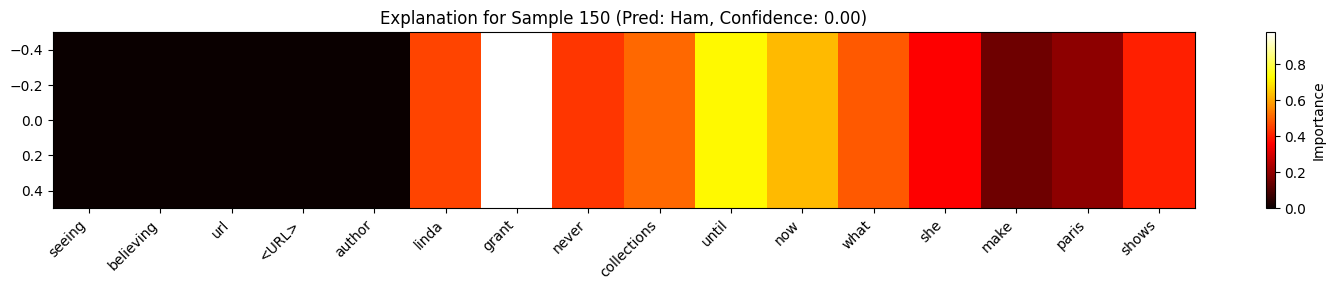

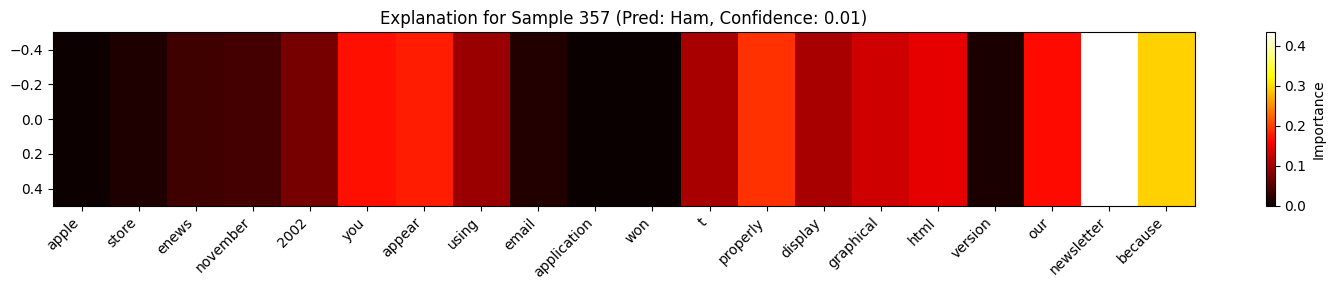

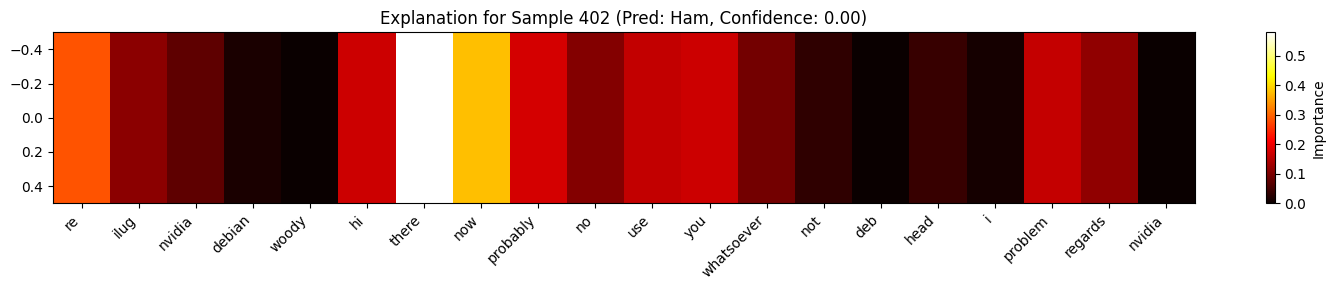

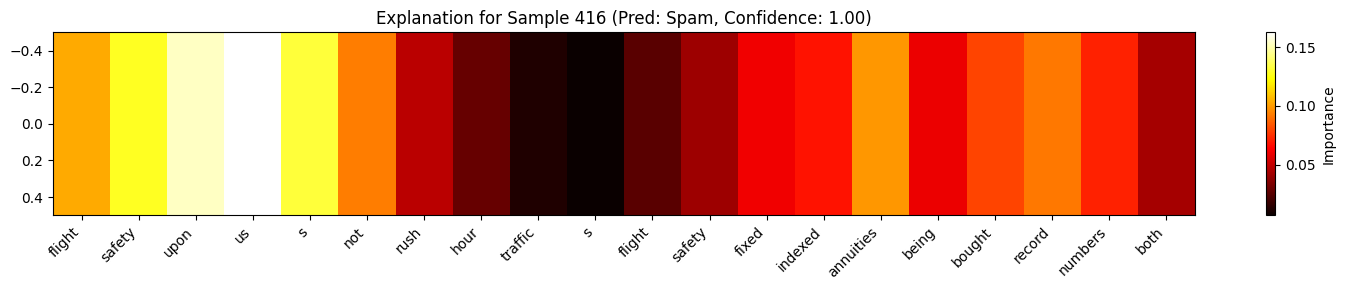

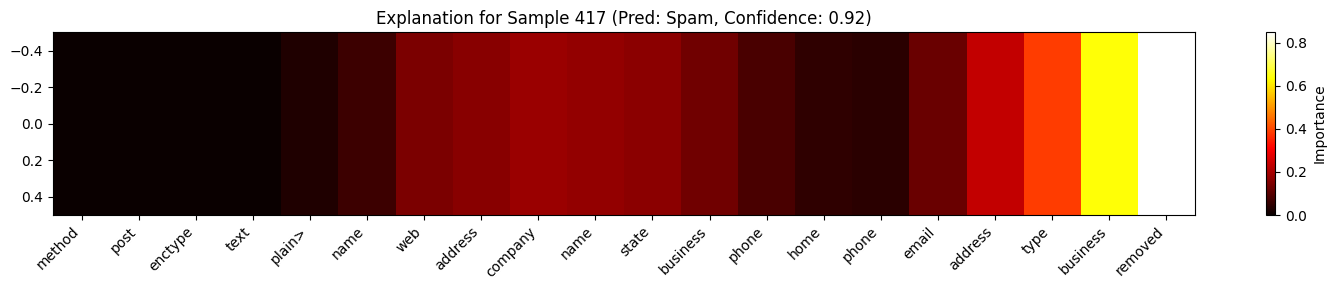

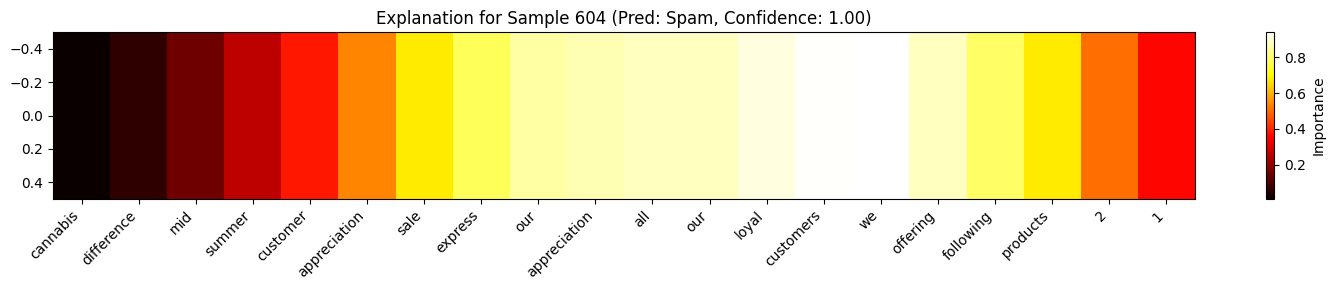

In [15]:
from integrations.grad_cam import visualize_explanation

# Visualize a few examples
print("\nVisualizing explanations for sample emails...")
for i in samples:
    visualize_explanation(
        test_df['text'].iloc[i],
        cam_maps[i],
        y_pred_probs[i].item(),
        i,
        20
    )